In [224]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [225]:
# video_frame = r'C:\technion\semester_8\project_b\datasets\large\asl_alphabet_train\asl_alphabet_train' #easy dataset
# video_frame = r'C:\technion\semester_8\project_b\datasets\significant\Training_Set' #diverse dataset
# video_frame = r'C:\technion\semester_8\project_b\videos_frame' #youtube dataset
video_frame = r'C:\technion\semester_8\project_b\datasets\big_dataset\ASL_Dataset\Train' #big dataset

In [226]:
grayscale = transforms.Grayscale(3)

test_transforms = transforms.Compose([
    # grayscale,
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [227]:
frame_dataset = datasets.ImageFolder(video_frame, transform=test_transforms)
video_samples = len(frame_dataset)
frame_dataset

Dataset ImageFolder
    Number of datapoints: 147682
    Root location: C:\technion\semester_8\project_b\datasets\big_dataset\ASL_Dataset\Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [228]:
num_classes = 25 # 29->26->25

In [229]:
torch.manual_seed(1)
indices = torch.randperm(video_samples)
frame_dataset = torch.utils.data.Subset(frame_dataset, indices)

In [230]:
frame_dataloader = torch.utils.data.DataLoader(dataset=frame_dataset,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=1)

In [231]:
classes = frame_dataloader.dataset.dataset.classes

In [232]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [233]:
model = torchvision.models.resnet50(pretrained=True)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load(r'C:\Users\wolf_\PycharmProjects\project_b\wandb\model_easy_set.pth'))

<All keys matched successfully>

1
2
23 / 29  mismatches
20.68965517241379 % of success


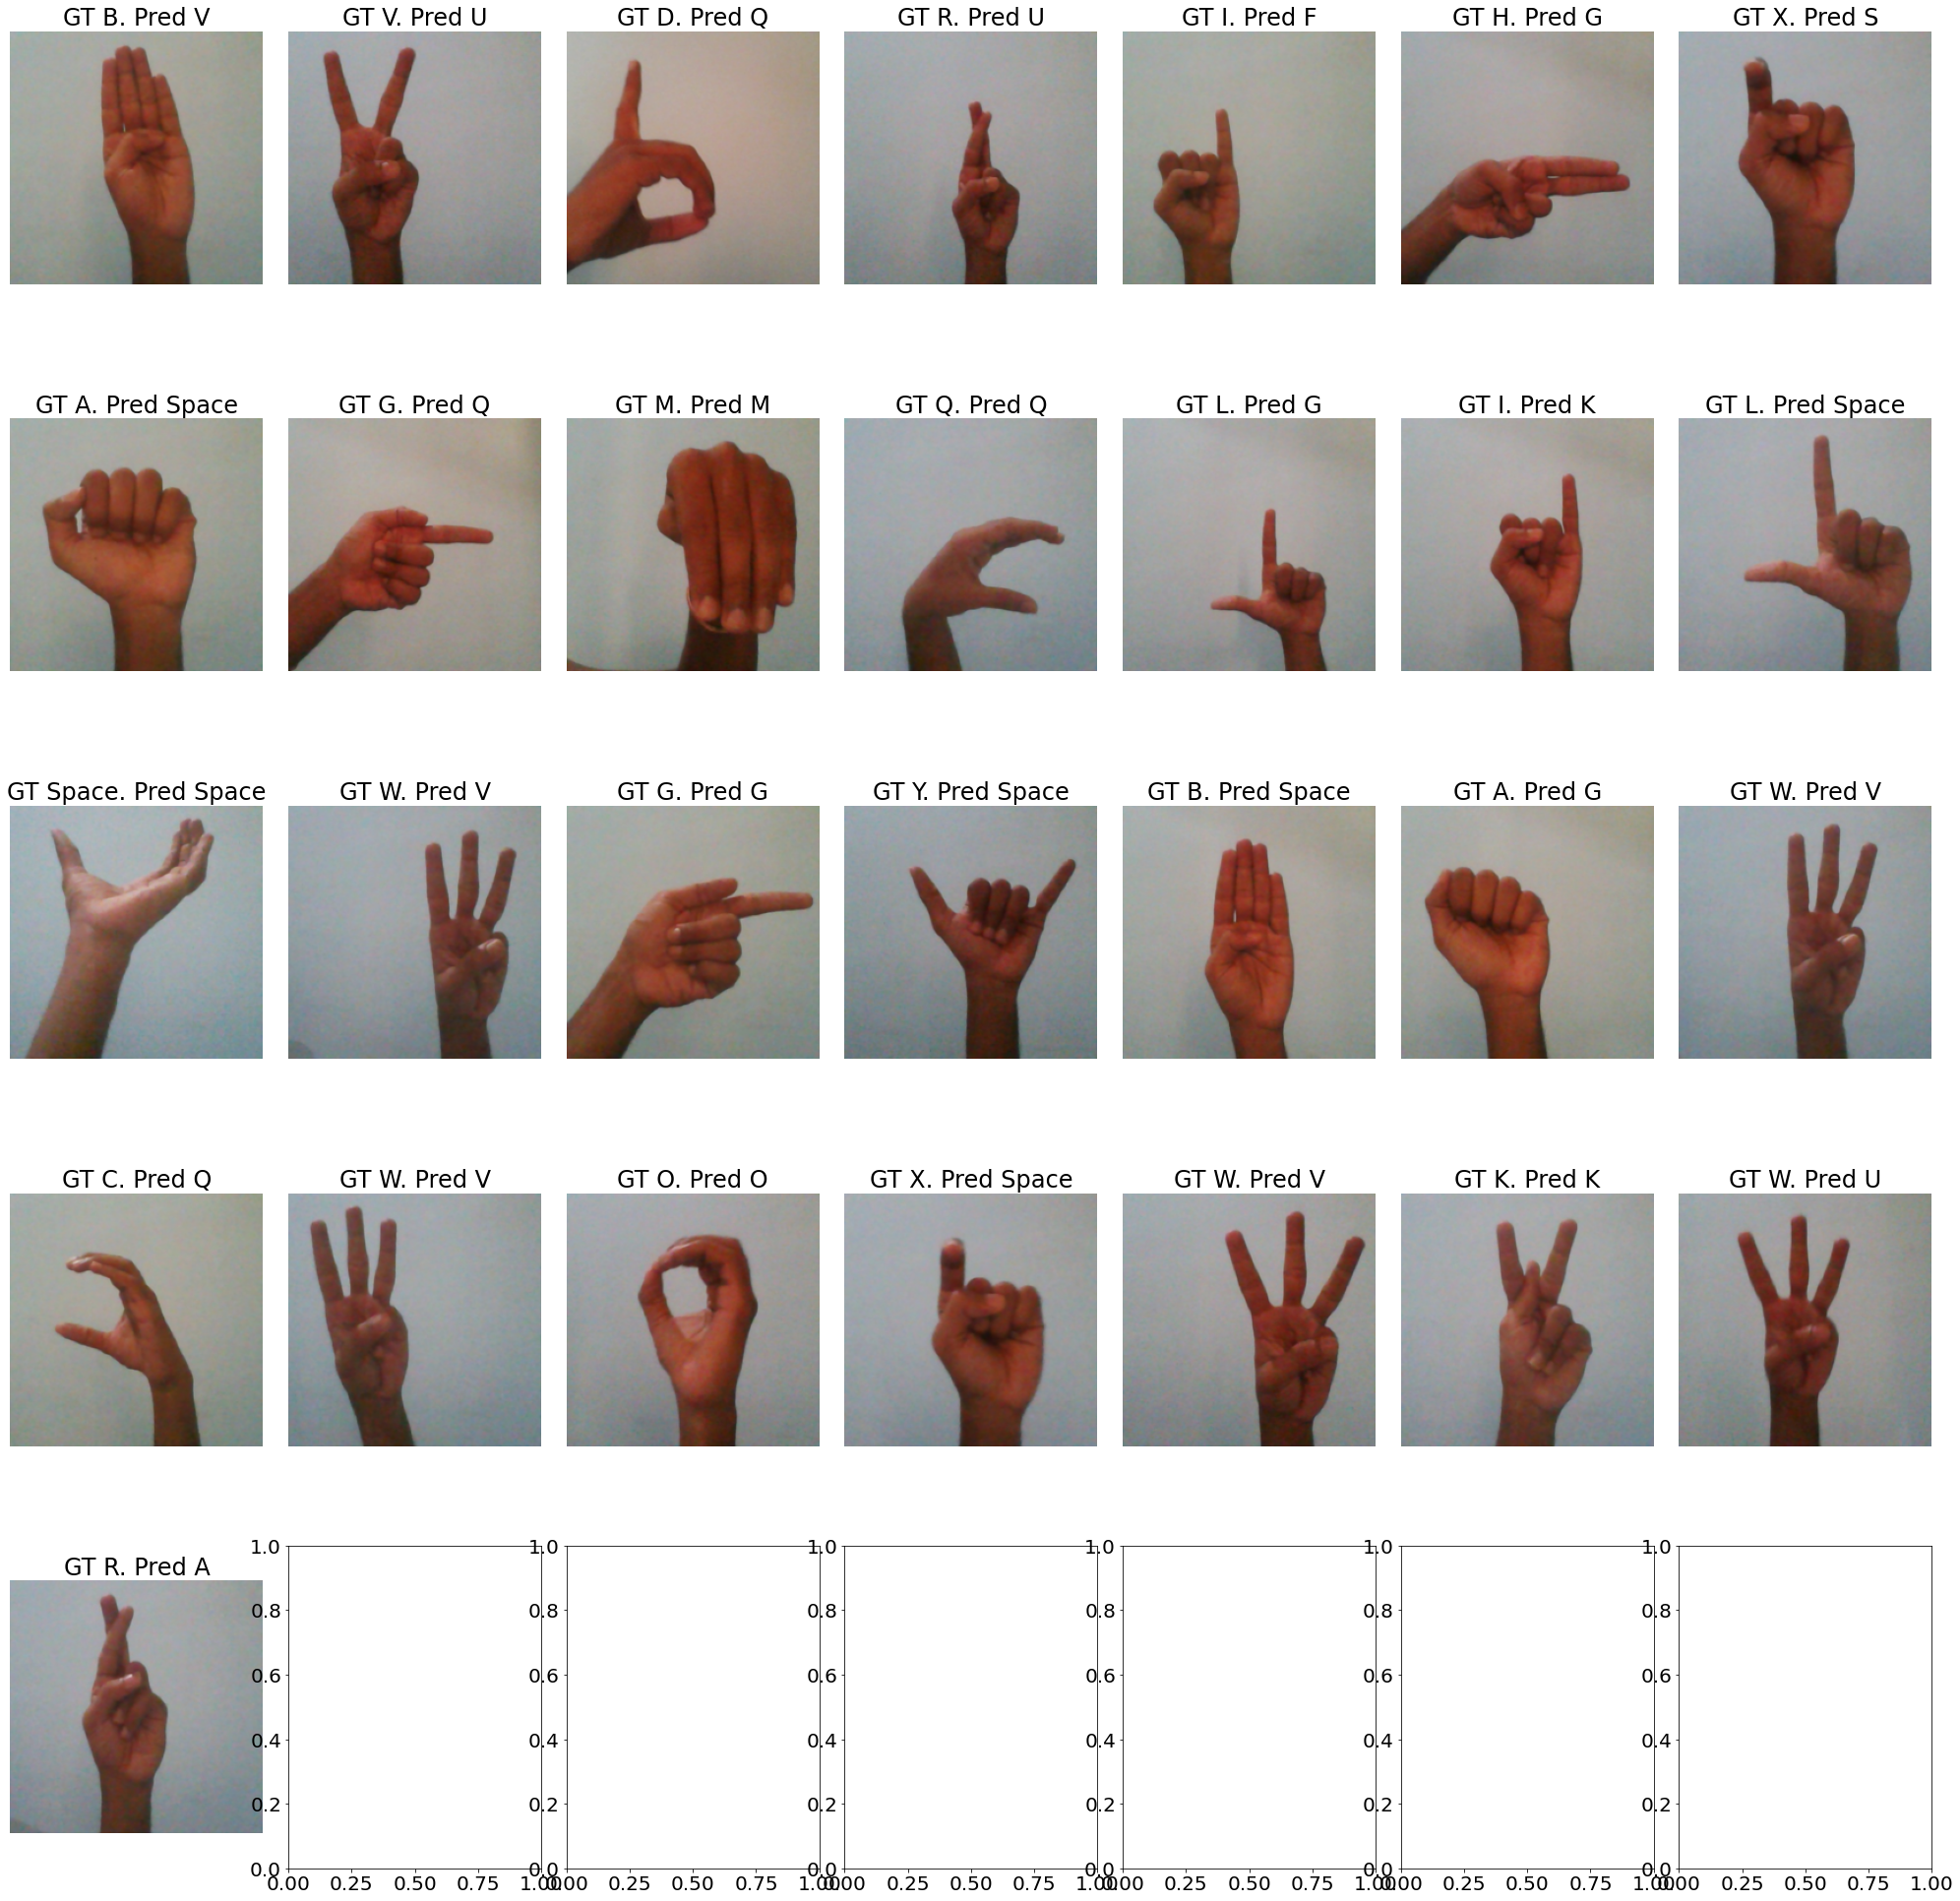

In [238]:
columns = 7
test_limit = 30
print_limit = 30
# row = round(len(frame_dataloader) / columns)+1
row = round(print_limit / columns)+1

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

i, j = 0, 0
test_counter = 1
num_pics = 0
mismatch_counter = 0
model.to(device)
print("1")
with torch.no_grad():
    model.eval()
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    all_preds = all_preds.to(device)
    all_labels = all_labels.to(device)
    print("2")

    for images, labels in frame_dataloader:
        # print("3")
        # test_counter += 1
        # if test_counter < print_limit:
        #     continue
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)

        num_pics+=1

        # print(f'GT {classes[labels[0]]}. Pred {classes[torch.max(output, dim=1)[1]]}')
        # plt.imshow(images[0].cpu().permute(1, 2, 0))
        # plt.axis('off')

        # if classes[labels[0]]=='X':
        ax[i][j].imshow(images[0].cpu().permute(1, 2, 0))
        ax[i][j].set_title(f'GT {classes[labels[0]]}. Pred {classes[torch.max(output, dim=1)[1]]}')
        ax[i][j].axis('off')

        j += 1
        if j == columns:
            j = 0
            i += 1

        if classes[labels[0]] != classes[torch.max(output, dim=1)[1]]:
            mismatch_counter += 1
            # print(f'GT {classes[labels[0]]}. Pred {classes[torch.max(output, dim=1)[1]]}')
            # plt.imshow(images[0].cpu().permute(1, 2, 0))
            # plt.axis('off')

            # ax[i][j].imshow(images[0].cpu().permute(1, 2, 0))
            # ax[i][j].set_title(f'GT {classes[labels[0]]}. Pred {classes[torch.max(output, dim=1)[1]]}')
            # ax[i][j].axis('off')
            #
            # j += 1
            # if j == columns:
            #     j = 0
            #     i += 1

        all_preds = torch.cat((all_preds, output),dim=0)
        all_labels = torch.cat((all_labels, labels),dim=0)



        # print(test_counter)
        test_counter += 1
        if test_counter%500 == 0:
            print(test_counter)
        if test_counter >= test_limit:
            break

    stacked = torch.stack(
                (
                    all_labels
                    ,all_preds.argmax(dim=1)
                )
                ,dim=1
            )
    print(mismatch_counter,"/",num_pics," mismatches")
    print((1-(mismatch_counter/num_pics))*100,"% of success")
    # plt.show()

In [235]:
cmt = torch.zeros(num_classes,num_classes, dtype=torch.int64)

for p in stacked:
    tl, pl = p.tolist()
    tl, pl = int(tl),int(pl)
    cmt[tl, pl] = cmt[tl, pl] + 1

In [236]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
tensor([[0.0077, 0.0000, 0.0000, 0.0000, 0.0000, 0.0154, 0.1846, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0462, 0.0000, 0.0385, 0.0000, 0.0000,
         0.7077, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0227, 0.0000, 0.0000, 0.0000, 0.0000, 0.0833, 0.1515, 0.0000, 0.0000,
         0.0455, 0.0000, 0.0758, 0.0000, 0.0530, 0.0000, 0.0303, 0.0758, 0.0000,
         0.3258, 0.0833, 0.0152, 0.0379, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0746, 0.0000, 0.0000, 0.0299, 0.0373, 0.0000, 0.0000,
         0.0000, 0.0672, 0.0000, 0.0000, 0.0000, 0.0000, 0.6418, 0.0000, 0.0000,
         0.1493, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0083, 0.1901, 0.0000, 0.0992, 0.1488, 0.0000, 0.0000,
         0.0000, 0.0165, 0.0000, 0.0000, 0.0661, 0.0000, 0.4711, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0148, 0.0000, 0.0000, 0.0000, 0.1630, 0.0370, 0.0

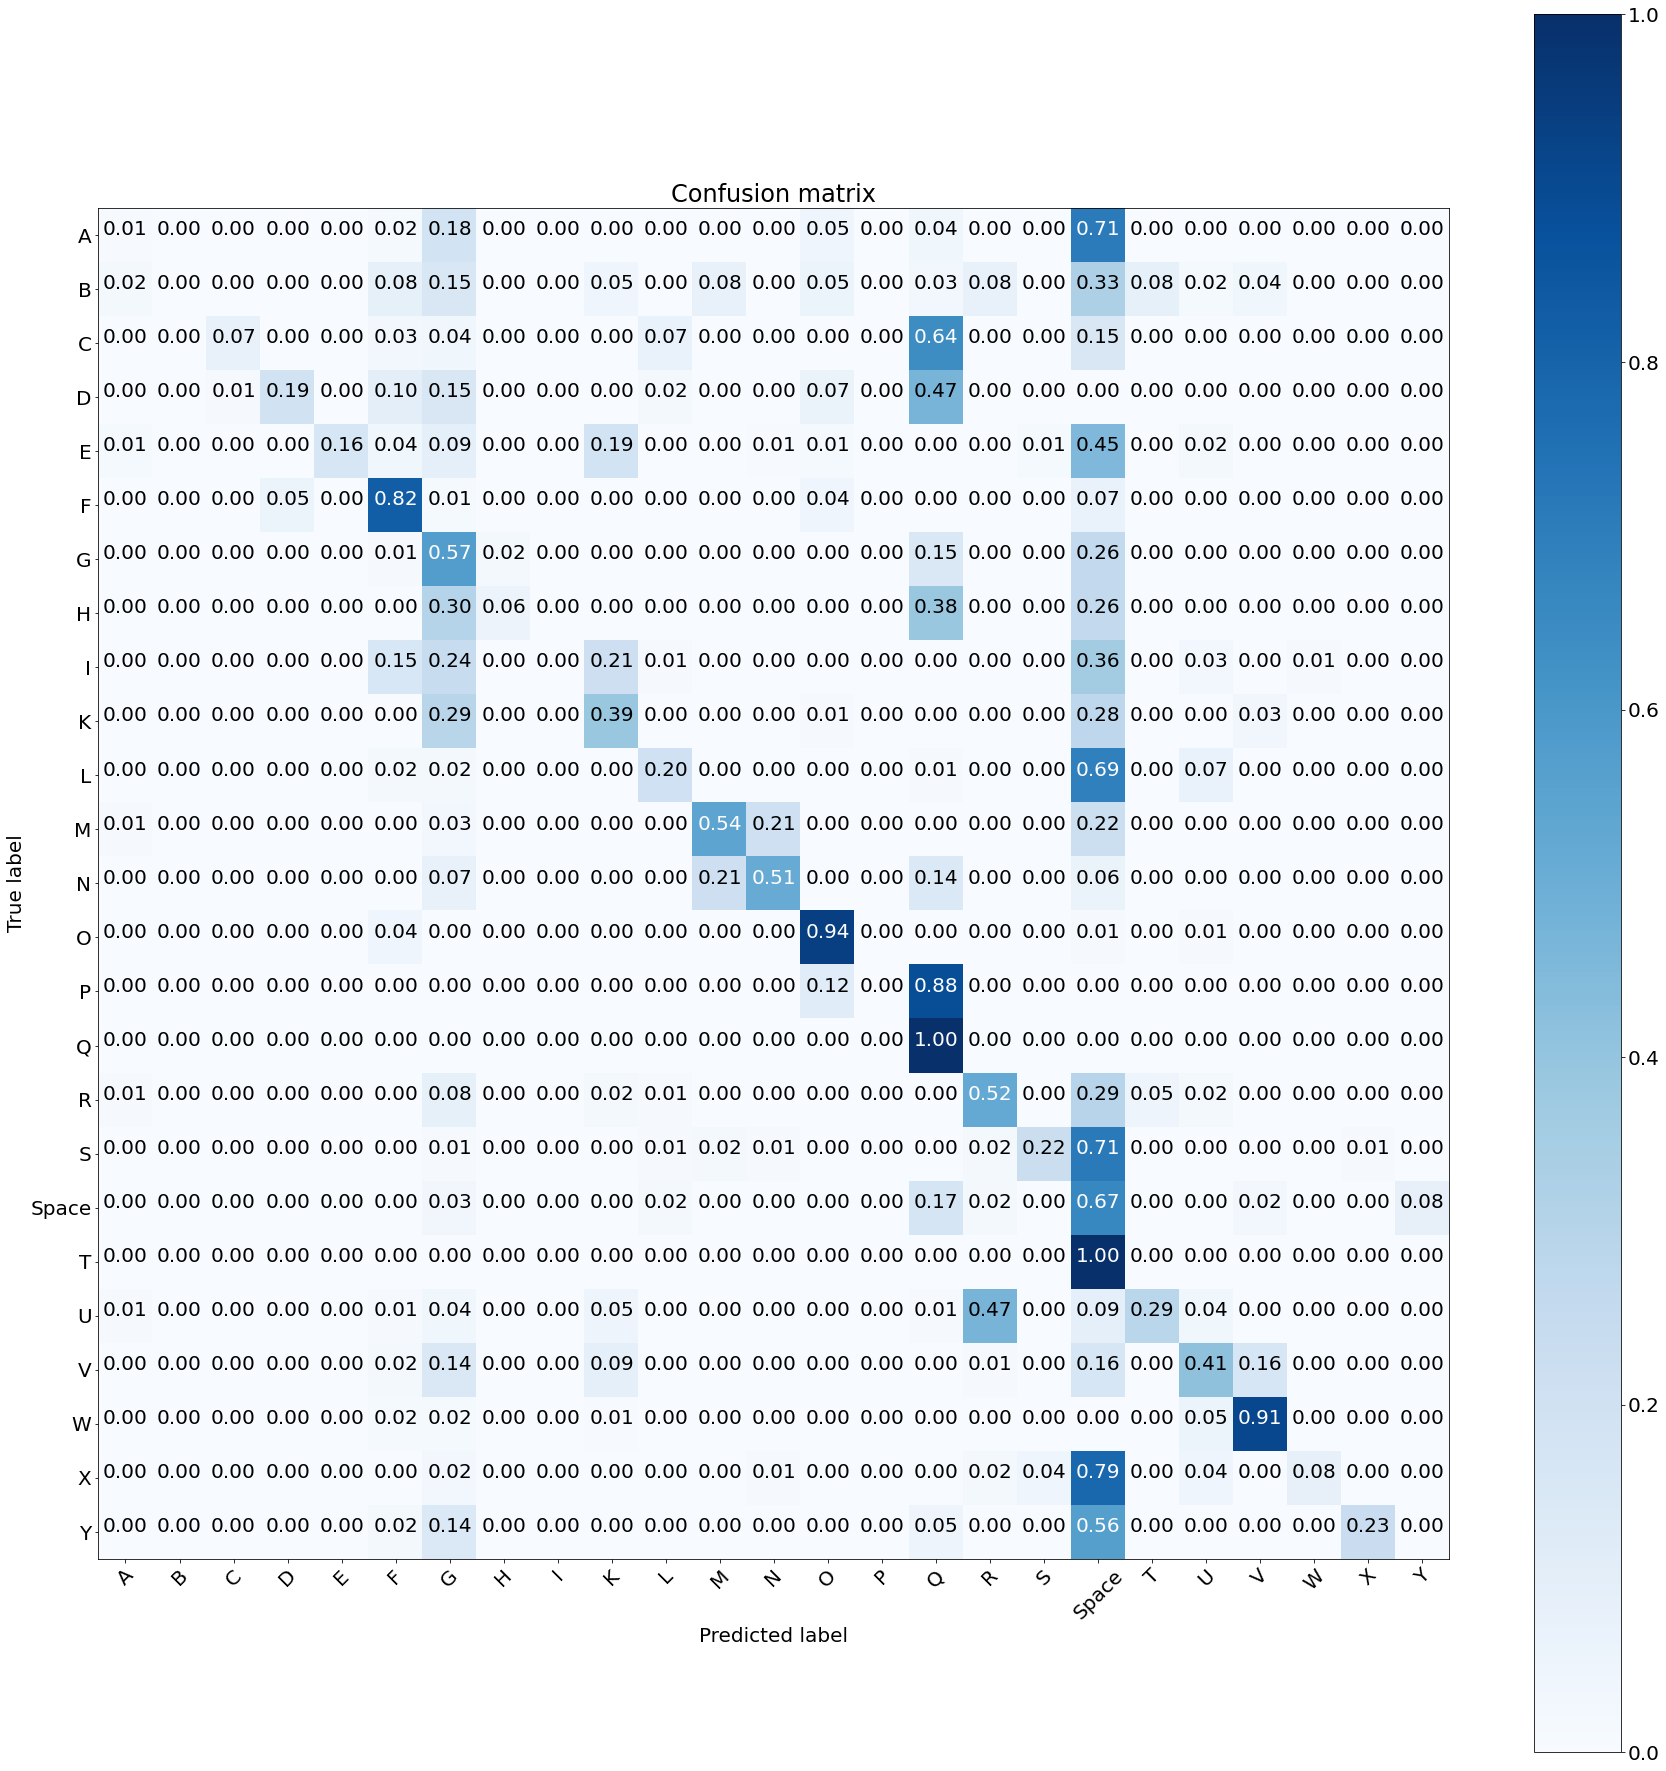

In [237]:
plt.figure(figsize=(num_classes,num_classes))
plot_confusion_matrix(cmt, classes, normalize=True)